# Dataset Analysis
A brief analysis from some relevants dataset

## CWRU

In [1]:
from vibdata.raw.CWRU.CWRU import CWRU_raw
from vibdata.deep.DeepDataset import DeepDataset
import numpy as np
from tqdm.notebook import tqdm
import torch
import plotly.express as px
import pandas as pd

/home/imsvarejao/vibnet-old/vibnetenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = DeepDataset("../data/deep_datasets/CWRU_std_scaler")
raw_dataset = CWRU_raw("../data/raw_datasets/", download=False)

print(f"Raw: {len(raw_dataset)}")
print(f"Deep: {len(dataset)}")

Raw: 294
Deep: 3042


In [9]:
metainfo = raw_dataset.getMetaInfo()
metainfo.head()

,fault_size,load,file_name,variable_name,axis,domain,sample_size,rotation_hz,label,sample_rate,component_location
0,0.0,0.0,97.mat,X097_DE_time,DE,time,243938,29.950000,0,12000,NaN
1,0.0,0.0,97.mat,X097_FE_time,FE,time,243938,29.950000,0,12000,NaN
2,0.0,1.0,98.mat,X098_DE_time,DE,time,483903,29.533333,0,12000,NaN
3,0.0,1.0,98.mat,X098_FE_time,FE,time,483903,29.533333,0,12000,NaN
4,0.0,2.0,99.mat,X099_DE_time,DE,time,485063,29.166667,0,12000,NaN


In [14]:
def divide_sample_rate(sample : pd.Series):
    # print(sample)
    sample = sample.copy()
    total_samples = int(sample["sample_size"] / sample["sample_rate"])
    result = pd.concat([sample] * total_samples, axis=1, ignore_index=True).T
    print(result)
    return result

deep_metainfo = metainfo.apply(divide_sample_rate, axis=1)
deep_metainfo.head()

   fault_size load file_name variable_name axis domain sample_size  \
0         0.0  0.0    97.mat  X097_DE_time   DE   time      243938   
1         0.0  0.0    97.mat  X097_DE_time   DE   time      243938   
2         0.0  0.0    97.mat  X097_DE_time   DE   time      243938   
3         0.0  0.0    97.mat  X097_DE_time   DE   time      243938   
4         0.0  0.0    97.mat  X097_DE_time   DE   time      243938   
5         0.0  0.0    97.mat  X097_DE_time   DE   time      243938   
6         0.0  0.0    97.mat  X097_DE_time   DE   time      243938   
7         0.0  0.0    97.mat  X097_DE_time   DE   time      243938   
8         0.0  0.0    97.mat  X097_DE_time   DE   time      243938   
9         0.0  0.0    97.mat  X097_DE_time   DE   time      243938   
10        0.0  0.0    97.mat  X097_DE_time   DE   time      243938   
11        0.0  0.0    97.mat  X097_DE_time   DE   time      243938   
12        0.0  0.0    97.mat  X097_DE_time   DE   time      243938   
13        0.0  0.0  

0       fault_size load file_name variable_name axi...
1       fault_size load file_name variable_name axi...
2       fault_size load file_name variable_name axi...
3       fault_size load file_name variable_name axi...
4       fault_size load file_name variable_name axi...
dtype: object

In [21]:
labels = np.array([ret["metainfo"]["label"] for ret in dataset])

In [27]:
df = pd.DataFrame({"label":labels})
for name, data in df.groupby("label"):
    print(name)
    print(data.size / df.shape[0])
    print(data.size, df.shape[0])

0
0.09204470742932282
280 3042
1
0.30046022353714663
914 3042
2
0.3037475345167653
924 3042
3
0.3037475345167653
924 3042


In [10]:
metainfo.fault_size.dtype

dtype('float64')

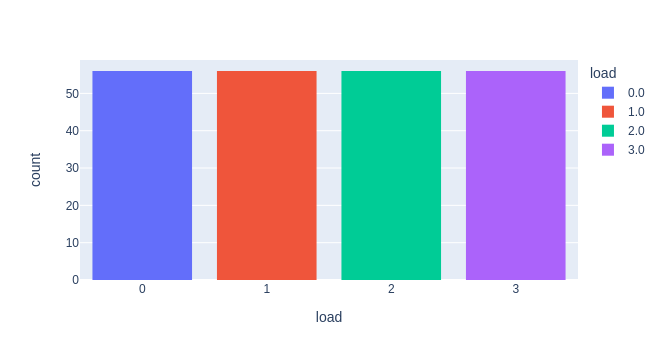

In [59]:
fig = px.histogram(metainfo, x='load', color='load')
fig.update_xaxes(type='category')
fig

In [14]:
metainfo.fault_size.unique()

array([0.   , 0.007, 0.014, 0.021,   nan])

In [3]:
%%time
accumulator = []
with tqdm(total=len(dataset), unit='sample') as pb:
    for i, data in enumerate(dataset):
        accumulator.append(
            data["metainfo"]["fault_size"]
        )
        pb.update()

groups = torch.Tensor(accumulator)
#groups = np.array([ret["metainfo"]["fault_size"] for ret in dataset])

  0%|          | 0/2440 [00:00<?, ?sample/s]

CPU times: user 26.7 s, sys: 2.27 s, total: 29 s
Wall time: 2min 24s


In [ ]:
groups.unique()
fault_size_df['fault_size'] = fault_size_df.fault_size.astype('')

In [41]:
fault_size_df.fault_size.dtype

dtype('float32')

In [39]:
fault_size_df = pd.DataFrame(groups, columns=['fault_size'])

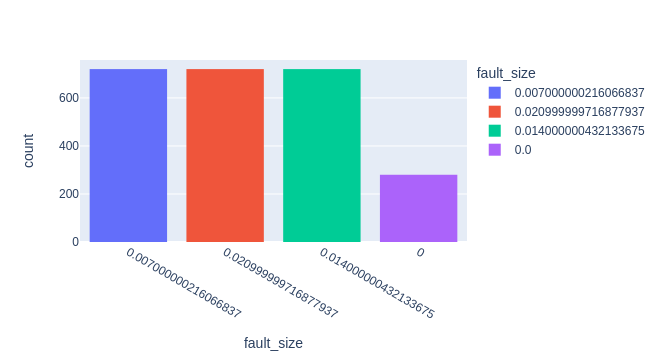

In [52]:
fig = px.histogram(fault_size_df, x='fault_size', color='fault_size')
fig.update_xaxes(type='category')
fig.update_layout(xaxis_tickformat = '%')

In [56]:
from sklearn.model_selection import RepeatedKFold

rpk = RepeatedKFold(n_splits=2, n_repeats=3)
X = np.random.random_sample(size=(8, 3))
y = np.random.randint(0, 2, 8)
for i, (x) in enumerate(rpk.split(X, y)):
    print(f"Fold {i}")

Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5


In [4]:
from sklearn.model_selection import LeaveOneGroupOut

logo = LeaveOneGroupOut()
folds = [fold for _, fold in logo.split(dataset, groups=groups)]

In [66]:
for i, fold in enumerate(folds):
    print(i, " -> ", len(fold))

0  ->  280
1  ->  720
2  ->  720
3  ->  720


In [11]:
class MemeDataset(torch.utils.data.Dataset):
    def __init__(self, src_dataset, standardize=False):
        self.dataset = src_dataset
        self.standardize = standardize

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx: int):
        ret = self.dataset[idx]
        X = ret["signal"]
        X = X.astype('float64')
        if isinstance(ret["metainfo"], pd.Series):
            y = ret["metainfo"]["label"]
        else:
            y = ret["metainfo"]["label"].values.reshape(-1, 1)

        if self.standardize:
            y -= self.dataset.metainfo["label"].min()
        y = y.astype('int')
        return X, y
        # return ("aba", "cbc")
        
meme_dataset = MemeDataset(dataset)

In [14]:
from torch.utils.data import SubsetRandomSampler, DataLoader
import numpy as np

#ids = torch.tensor(np.concatenate(folds[0:2]), dtype=torch.int32)
ids = np.concatenate(folds[0:2])

In [18]:
ids[0]

tensor(620, dtype=torch.int32)

In [15]:
test_sampler = SubsetRandomSampler(ids)
print(test_sampler)
print(len(test_sampler))
# for data in test_sampler:
    # print(data, end=', '

1000


In [12]:
meme_dataset[0][0]

array([[0.01553163, 0.01570467, 0.01587771, ..., 0.02532206, 0.02191563,
        0.0185092 ]])

In [ ]:
def foo(batch):
    print("Passing")
    batch = []
    return torch.tensor(x)

test_loader = DataLoader(meme_dataset, sampler=test_sampler, batch_size=2)

for data, y in test_loader:
    print(data, "\n\n====\n\n", y)
    exit(1)
    print(1, end=',')
# for data in test_sampler:
    # print(data)

## Plot temporal signal

In [36]:
raw_dataset = CWRU_raw('../../datasets/')
ret = raw_dataset[290]
print(ret)
sig = ret['signal'][0]
metainfo = ret['metainfo']

{'signal': array([array([-0.03338667, -0.032552  , -0.02420533, ..., -0.00918133,
              -0.00166933, -0.00417333])                              ],
      dtype=object), 'metainfo':      fault_size  load file_name variable_name axis domain  sample_size  \
290         NaN   NaN   264.mat  X264_DE_time   DE   time       486804   

     rotation_hz  label  sample_rate component_location  
290    29.166667      2        48000                 DE  }


In [37]:
len(sig)

486804

0 486804


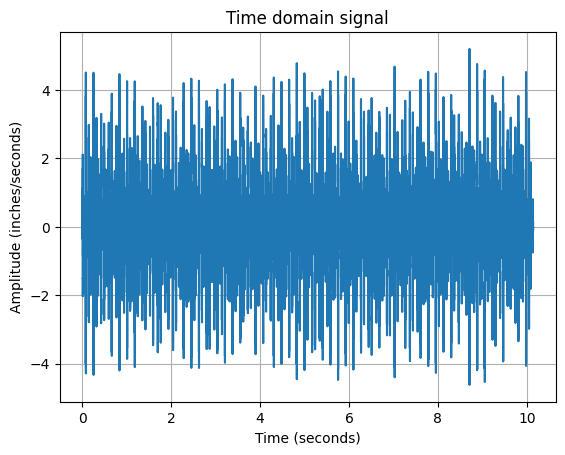

In [40]:
import matplotlib.pyplot as plt
import numpy as np
print(0, len(sig))

x = np.linspace(start=0, stop=len(sig), num=len(sig))
x /= metainfo['sample_rate'].values[0]

plt.plot(x, sig)
plt.ylabel('Amplitude (inches/seconds)')
plt.xlabel('Time (seconds)')
plt.title('Time domain signal')
plt.grid()
plt.savefig('time_domain_signal.png')

<Figure size 640x480 with 0 Axes>